In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [ ]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [ ]:
total_score_df = delivery.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()

In [ ]:
total_score_df = total_score_df[total_score_df['inning']== 1]

In [ ]:
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on= 'id', right_on= 'match_id')
match_df

In [ ]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [ ]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')



In [ ]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]


In [ ]:
match_df.shape

In [ ]:
match_df = match_df[match_df['dl_applied'] == 0]
match_df

In [ ]:
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]
match_df

In [ ]:
delivery_df = match_df.merge(delivery, on= 'match_id')

In [ ]:
delivery_df = delivery_df[delivery_df['inning'] == 2]
delivery_df.shape

In [ ]:
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()

In [ ]:
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score'] 

In [ ]:
delivery_df['balls_left'] = 120 - ((delivery_df['over'] - 1) * 6 + delivery_df['ball'])
delivery_df

In [ ]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
Wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets'] = 10 - Wickets
delivery_df

In [ ]:
delivery_df['crr'] = ((delivery_df['current_score'])*6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']
delivery_df

In [ ]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [ ]:
delivery_df['result'] = delivery_df.apply(result,axis=1)
delivery_df

In [ ]:
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr', 'result']]
final_df

In [ ]:
final_df = final_df.sample(final_df.shape[0])

In [ ]:
final_df.sample()
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]
final_df

In [ ]:
X = final_df.iloc[:,:-1]
y= final_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

In [ ]:
trf = ColumnTransformer(
    [
        ('trf',OneHotEncoder(sparse_output=False,drop='first'),['batting_team', 'bowling_team', 'city'])
    ]
    ,remainder='passthrough'
)

In [ ]:
pipe = Pipeline(
    [
        ('step1', trf),
        
        ('step2', LogisticRegression(solver='liblinear'))
    ]
)

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
pipe.predict_proba(X_test)[99]

In [ ]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))

In [ ]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target

In [ ]:
temp_df,target = match_progression(delivery_df,74,pipe)
temp_df

Text(0.5, 1.0, 'Target-178')

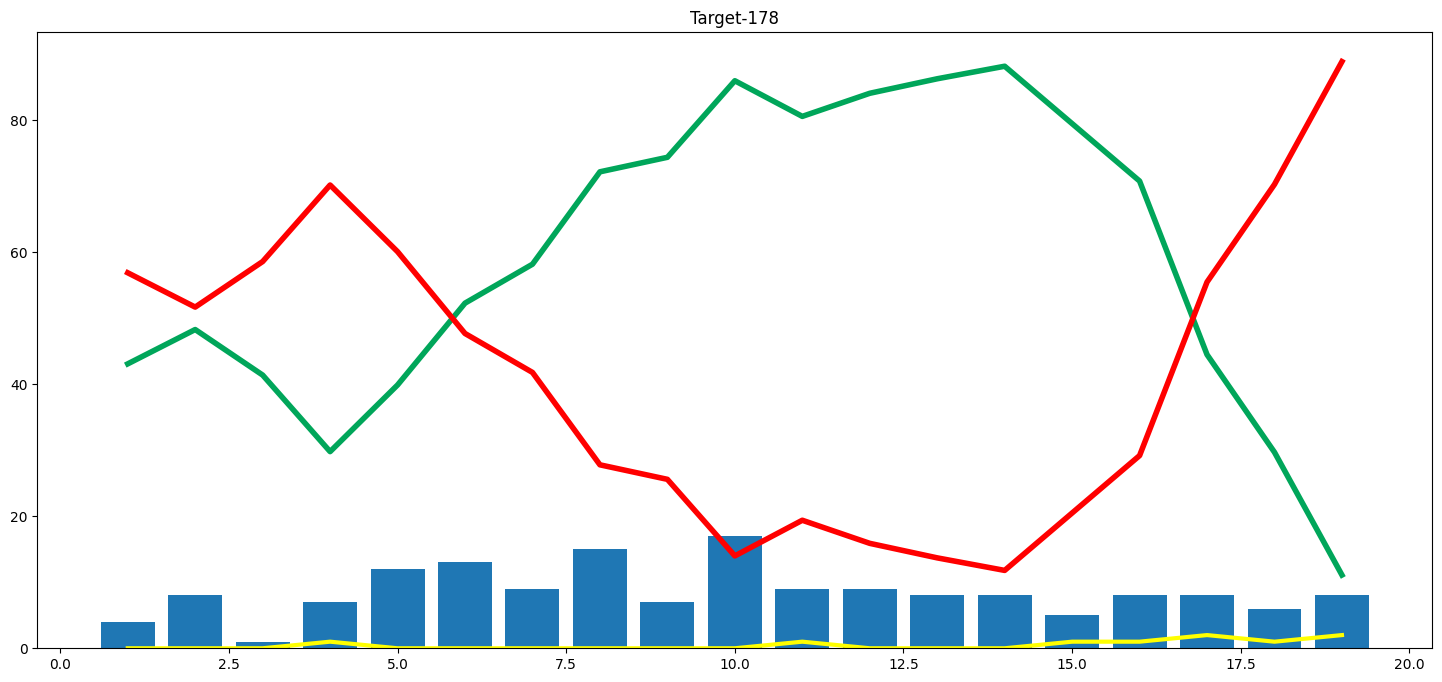

In [373]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [375]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [377]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [378]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))